In [4]:
#Notebook to analize diffraction patterns from OHM sponge
# this is part of the Vikas/Stephanie paper on the synthesis/characterization of the MNS@OHM spomge

In [1]:
%matplotlib qt5

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skued import gaussian
import hyperspy.api as hp
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [3]:
# importing figure using hyperspy to get the scale bar
#this could be done alternatively using dm.reader from ncempy
#from ncempy.io import dm;
#dmData = dm.dmReader('path/to/file/data.dm3') #a simple one image data file
#plt.imshow(dmData['data']) #show the image using pyplot

im = hp.load('Data/OneView -400X -8E-e -200kV -0215.dm4')
scale = im.axes_manager[0].scale  #scale in 1/nm
size=im.axes_manager[0].size

In [4]:
#plt.imshow(im, vmin = -100, vmax = 5000, cmap = 'viridis')

hp.plot.plot_images(im, scalebar='all', cmap= 'viridis', vmin = 0, vmax = 8000)

In [5]:
# import figure with diffread from skued package

from skued import diffread

im01 = diffread('Data/OneView -400X -8E-e -200kV -0215.dm4')
plt.imshow(im01, vmin = 0, vmax = 8000, cmap = 'viridis')
plt.axis('off')


(-0.5, 4095.5, 4095.5, -0.5)

In [6]:
#finding center point for azimuthal average integration 

from skued.image import powder_center
from skued import mask_from_collection
ic, jc = powder_center(im01)

In [7]:
# Making a mask and plotting the center as a black disk
import numpy as np
ii, jj = np.meshgrid(np.arange(im.axes_manager[0].size), np.arange(im.axes_manager[1].size),indexing = 'ij')

#ii, jj = np.meshgrid(np.arange(im01.shape[0]), np.arange(im01.shape[1]),indexing = 'ij')
rr = np.sqrt((ii - ic)**2 + (jj - jc)**2)

h = plt.contourf(ii,jj,rr)
plt.axis('equal')
plt.show()


In [8]:
#im01.setflags(write=1)
im.data[rr < 200] = 0

plt.imshow(im, vmin = -100, vmax = 5000, cmap = 'viridis')
plt.axis('off')

(-0.5, 4095.5, 4095.5, -0.5)

In [9]:
from skued import azimuthal_average
radius, intensity = azimuthal_average(im01, (ic, jc))
radius = radius*scale; #to scale in 1/nm
intensity = intensity/max(intensity)
plt.plot(radius, intensity)


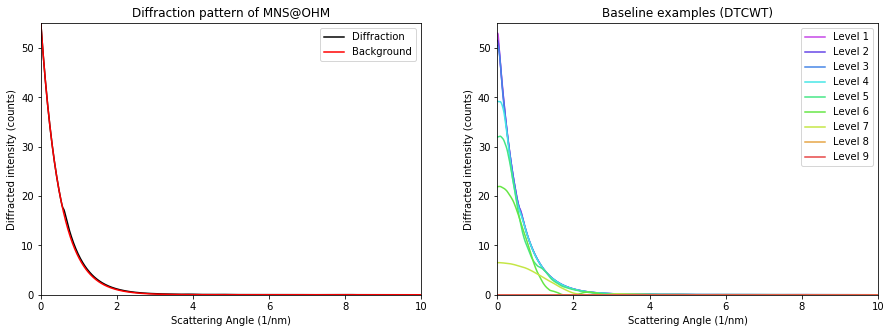

In [31]:
#removing background

from skued import gaussian, spectrum_colors
from skued import baseline_dt

diffuse = 0* np.exp(-7 * radius) + 55 * np.exp(-2 *radius)
substrate1 = 0.2* gaussian(radius, center = 0, fwhm = radius.mean()/4)
substrate2 = 0 * gaussian(radius, center = radius.mean()/2.5, fwhm = radius.mean()/4)

#baseline = baseline_dt(radius, wavelet = 'qhisft3', level = 6, max_iter = 150)


signal = intensity + diffuse + substrate1 + substrate2
levels = list(range(1,10))
colors = spectrum_colors(levels)

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

ax1.plot(radius, signal, 'k-', label = 'Diffraction')
ax1.plot(radius, diffuse + substrate1 + substrate2, 'r', label = 'Background')
ax1.set_title('Diffraction pattern of MNS@OHM')

for l, c in zip(levels, colors):
        baseline = baseline_dt(signal, level = l, max_iter = 150, wavelet = 'qshift3')
        ax2.plot(radius, baseline, color = c, label = f'Level {l}')

        ax2.set_title('Baseline examples (DTCWT)')

for ax in (ax1, ax2):
        ax.set_xlabel('Scattering Angle (1/nm)')
        ax.set_ylabel('Diffracted intensity (counts)')
        ax.set_xlim([radius.min(), 10])
        ax.set_ylim([0, signal.max()])
        ax.legend()
plt.show()


In [10]:
from skued import Crystal
Fe3O4 = Crystal.from_cif('Data/Fe3o4 spinel.cif')
graphite = Crystal.from_cif('Data/graphite.cif')

In [11]:
from skued import powdersim
q = np.linspace(3, 11, 1024)
diff01 = powdersim(graphite, q)
diff02 = powdersim(Fe3O4, q)

diff01_norm=diff01/diff01.max()
diff02_norm=diff02/diff02.max()

plt.plot(q, diff01/diff01.max(), 'k-', q, diff02/diff02.max(), 'r', 
         label = ['Graphite', 'Fe2O3'])

plt.xlim([q.min(), q.max()])
plt.xlabel('$q (1/A)$')
plt.ylabel('Diffracted intensity (A.u.)')
plt.title('Polycrystalline graphite diffraction')

Text(0.5, 1.0, 'Polycrystalline graphite diffraction')

In [12]:
from crystals import Crystal, Atom
lattice_vectors = [8.39690,  8.39690,  8.39690]
lattice_vectors

[8.3969, 8.3969, 8.3969]

In [13]:
from scipy.signal import find_peaks
graphite_peaks, _ =find_peaks(diff01_norm, height=0.18)
iron_peaks, _ =find_peaks(diff02_norm, height=0.18)

graphite_levels = q[graphite_peaks]*0.89
iron_levels=q[iron_peaks]*0.89

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_aspect(1)
theta = np.linspace(0, np.pi, 200)

ax.imshow(im, vmin = -100, vmax = 5000, cmap = 'viridis')

for l in graphite_levels:
   ax.plot(l*np.sin(theta)/scale + ic + 15, 1.005*l*np.cos(theta)/scale + jc +10, 
            '--', linewidth=1, color='white')

for l in iron_levels:
   ax.plot(l*np.sin(theta)/scale + ic + 15, 1.005*l*np.cos(theta)/scale + jc +10,
            '--', linewidth=1, color='orangered')


scalebar = AnchoredSizeBar(
        transform=ax.transAxes, label="", size=10/scale/size,
        loc=4, borderpad=2,label_top=True, frameon=False,
        color='white', size_vertical=0.005)
ax.add_artist(scalebar)
ax.set_axis_off()
fig.savefig("diff_300dpi.png", dpi=300)